# Clustering & PCA Assignment

In [1]:
import warnings
import numpy as np
import pandas as pd
# for plots
import matplotlib.pyplot as plt
import seaborn as sns
# for scaling
from sklearn.preprocessing import StandardScaler
# for hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
# For PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
# For silhoutte analysis
from sklearn.metrics import silhouette_score
# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
#ignore warnings
warnings.filterwarnings('ignore')
# Set pretty printing format for floats
pd.set_option('float_format', '{:.2f}'.format)

In [3]:
# reading the csv
country_df = pd.read_csv('./Country-data.csv')
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.20,10.00,7.58,44.90,1610,9.44,56.20,5.82,553
1,Albania,16.60,28.00,6.55,48.60,9930,4.49,76.30,1.65,4090
2,Algeria,27.30,38.40,4.17,31.40,12900,16.10,76.50,2.89,4460
3,Angola,119.00,62.30,2.85,42.90,5900,22.40,60.10,6.16,3530
4,Antigua and Barbuda,10.30,45.50,6.03,58.90,19100,1.44,76.80,2.13,12200


In [4]:
country_df.shape

(167, 10)

#### Checking for missing values

In [5]:
round(100*(country_df.isnull().sum()/len(country_df.index)), 2)

country      0.00
child_mort   0.00
exports      0.00
health       0.00
imports      0.00
income       0.00
inflation    0.00
life_expec   0.00
total_fer    0.00
gdpp         0.00
dtype: float64

We don't have any missing values.

#### Checking for duplicates

In [6]:
#Checking for duplicates
len(country_df.duplicated(subset=None, keep='first'))

167

No change in the number of rows, there are no duplicates

In [7]:
#Converting exports,imports and health spending percentages to absolute values.
country_df['exports'] = country_df['exports']*country_df['gdpp']/100
country_df['imports'] = country_df['imports']*country_df['gdpp']/100
country_df['health'] = country_df['health']*country_df['gdpp']/100
country_df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.20,55.30,41.92,248.30,1610,9.44,56.20,5.82,553
1,Albania,16.60,1145.20,267.89,1987.74,9930,4.49,76.30,1.65,4090
2,Algeria,27.30,1712.64,185.98,1400.44,12900,16.10,76.50,2.89,4460
3,Angola,119.00,2199.19,100.61,1514.37,5900,22.40,60.10,6.16,3530
4,Antigua and Barbuda,10.30,5551.00,735.66,7185.80,19100,1.44,76.80,2.13,12200


#### Checking the spread of the data

In [8]:
country_df.describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00,167.00
mean,38.27,7420.62,1056.73,6588.35,17144.69,7.78,70.56,2.95,12964.16
std,40.33,17973.89,1801.41,14710.81,19278.07,10.57,8.89,1.51,18328.70
min,2.60,1.08,12.82,0.65,609.00,-4.21,32.10,1.15,231.00
1%,2.80,22.24,17.01,104.91,742.24,-2.35,47.16,1.24,331.62
5%,3.46,70.47,26.72,169.28,1213.00,0.18,55.78,1.39,465.90
10%,4.20,110.22,36.50,211.01,1524.00,0.59,57.82,1.45,593.80
25%,8.25,447.14,78.54,640.21,3355.00,1.81,65.30,1.79,1330.00
50%,19.30,1777.44,321.89,2045.58,9960.00,5.39,73.10,2.41,4660.00
75%,62.10,7278.00,976.94,7719.60,22800.00,10.75,76.80,3.88,14050.00


Although we can see that the values less than 5th percentile and more than 95th percentile look like outliers, we cannot remove them since they could be values for different countries. Also, we cannot say for sure that such large values cannot exist. They can be true for the country they belong to. Also, the high and low values is what the clustering is going to be based on.
<br>Also, on removing the outliers we might miss the variance from the data.
<br>Another reason is that the dataset is quite small, and outlier treatment might lead to significant loss of information.

In [9]:
# putting all the feature variables in a separate dataframe
country_feature_df = country_df.drop('country',axis=1)

In [10]:
# Since the continous variables have different scales, standardizing the data using standard scaler
scaler = StandardScaler()
country_feature_scaled_df=pd.DataFrame(scaler.fit_transform(country_feature_df),columns=country_feature_df.columns)
country_feature_scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.29,-0.41,-0.57,-0.43,-0.81,0.16,-1.62,1.90,-0.68
1,-0.54,-0.35,-0.44,-0.31,-0.38,-0.31,0.65,-0.86,-0.49
2,-0.27,-0.32,-0.48,-0.35,-0.22,0.79,0.67,-0.04,-0.47
3,2.01,-0.29,-0.53,-0.35,-0.59,1.39,-1.18,2.13,-0.52
4,-0.70,-0.10,-0.18,0.04,0.10,-0.60,0.70,-0.54,-0.04


In [11]:
country_feature_scaled_df = (country_feature_df-country_feature_df.mean())/(country_feature_df.std())
country_feature_scaled_df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.29,-0.41,-0.56,-0.43,-0.81,0.16,-1.61,1.90,-0.68
1,-0.54,-0.35,-0.44,-0.31,-0.37,-0.31,0.65,-0.86,-0.48
2,-0.27,-0.32,-0.48,-0.35,-0.22,0.79,0.67,-0.04,-0.46
3,2.00,-0.29,-0.53,-0.34,-0.58,1.38,-1.18,2.12,-0.51
4,-0.69,-0.10,-0.18,0.04,0.10,-0.60,0.70,-0.54,-0.04


### PCA on the data

In [12]:
pca = PCA(svd_solver='randomized', random_state=42)

In [13]:
#Doing PCA on the data
pca_df = pca.fit_transform(country_feature_scaled_df)

In [14]:
# Checking the variance given by the PCs
pca.explained_variance_ratio_.round(2)

array([0.59, 0.18, 0.1 , 0.06, 0.03, 0.02, 0.01, 0.  , 0.  ])

More than 90% of the variance is explained by the first 4 PCs. Plotting a scree plot for the explained variance.

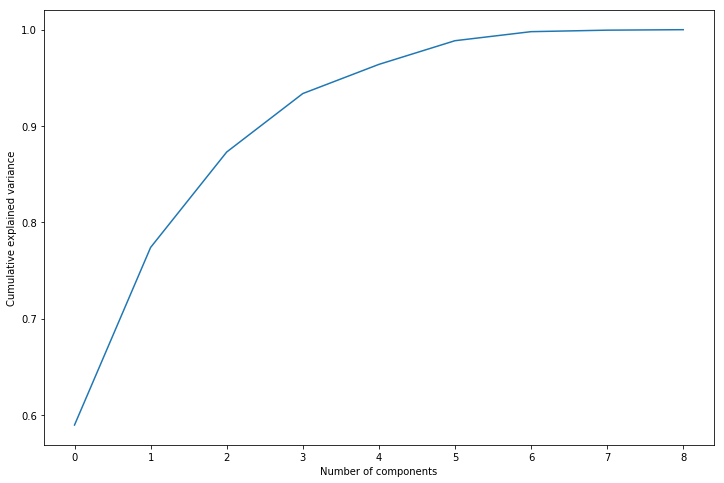

In [15]:
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

It can be seen that 4 PCs are enough to explain ~94% of variance. Considering only the first 4 PCs for further analysis.

In [16]:
# Finally performing Incremental PCA for dimensionality reduction.
pca_inc = IncrementalPCA(n_components=4)
pca_df = pca_inc.fit_transform(country_feature_scaled_df)

In [17]:
pca_df = np.transpose(pca_df)
pca_df = pd.DataFrame({'PC1':pca_df[0],'PC2':pca_df[1],'PC3':pca_df[2],'PC4':pca_df[3]})
pca_df.head()

,PC1,PC2,PC3,PC4
0,-2.63,1.47,-0.54,0.24
1,-0.02,-1.43,-0.01,-0.44
2,-0.46,-0.68,0.96,-0.18
3,-2.72,2.17,0.60,0.44
4,0.65,-1.02,-0.24,-0.27


### Clustering

First calculating Hopkins statistic to check the clustering-tendency for this data.

In [18]:
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

hopkins(pca_df)

0.9457867286599859

A value between 0.7 and 0.99 shows that the data has a high tendency to cluster

### K Means

Finding appropriate number of clusters

#### Silhoutte Analysis

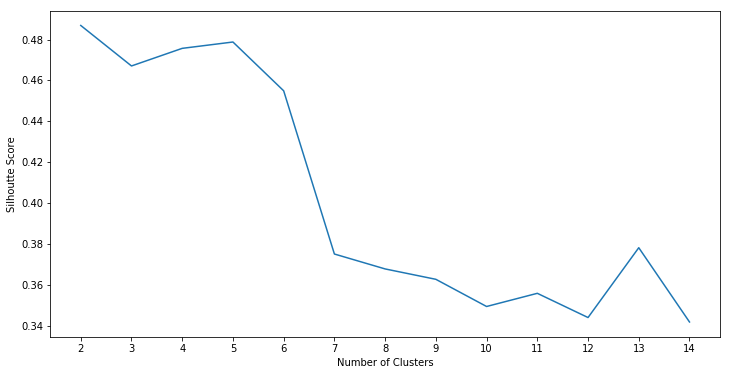

In [19]:
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k,init='k-means++',random_state=42).fit(pca_df)
    sse_.append([k, silhouette_score(pca_df, kmeans.labels_)])
fig = plt.figure(figsize = (12,6))
plt.xticks(np.arange(2, 16, 1.0))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

We can see that the Silhoutte score is high for k between 2 to 5, and then drops drastically beyond 5.

#### Plotting Sum of Squared Distances

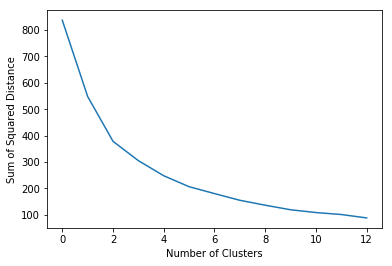

In [20]:
ssd = []
for num_clusters in list(range(2,15)):
    model_clus = KMeans(n_clusters = num_clusters, init='k-means++',random_state=42, max_iter=50)
    model_clus.fit(pca_df)
    ssd.append(model_clus.inertia_)
plt.ylabel('Sum of Squared Distance')
plt.xlabel('Number of Clusters')
plt.plot(ssd)

From the above plot, points 2 to 5 look like appropriate number of clusters that can be taken.

Taking k = 4.

In [21]:
# Kmeans with K=4
model_clus4 = KMeans(n_clusters = 4, init='k-means++',random_state=42, max_iter=50)
model_clus4.fit(pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [22]:
# Checking for number of countries in each cluster
pd.Series(model_clus4.labels_).value_counts()

0    87
2    48
3    30
1     2
dtype: int64

We can see that we have 1 cluster with only two members. Taking cluter number = 3 so that each cluster has at least 5% of the data. The clusters when formed should represent the following grouping: <br>Developed Countries<br>Developing Countries<br>Under-Developed Countries

In [23]:
# Kmeans with K=3
model_clus3 = KMeans(n_clusters = 3, init='k-means++',random_state=42, max_iter=50)
model_clus3.fit(pca_df)
# Checking for number of countries in each cluster
pd.Series(model_clus3.labels_).value_counts()

0    91
1    48
2    28
dtype: int64

To perform analysis on the clusters, we will concatenate the original dataframe, the principal components with the cluster labels.

In [24]:
country_df_km = pd.concat([country_df, pca_df, pd.Series(model_clus3.labels_)], axis=1)
country_df_km.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','PC1','PC2','PC3','PC4','cluster_id']
country_df_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
0,Afghanistan,90.20,55.30,41.92,248.30,1610,9.44,56.20,5.82,553,-2.63,1.47,-0.54,0.24,1
1,Albania,16.60,1145.20,267.89,1987.74,9930,4.49,76.30,1.65,4090,-0.02,-1.43,-0.01,-0.44,0
2,Algeria,27.30,1712.64,185.98,1400.44,12900,16.10,76.50,2.89,4460,-0.46,-0.68,0.96,-0.18,0
3,Angola,119.00,2199.19,100.61,1514.37,5900,22.40,60.10,6.16,3530,-2.72,2.17,0.60,0.44,1
4,Antigua and Barbuda,10.30,5551.00,735.66,7185.80,19100,1.44,76.80,2.13,12200,0.65,-1.02,-0.24,-0.27,0


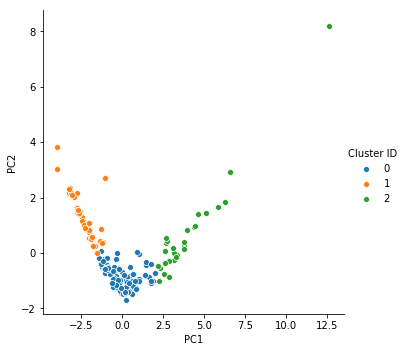

In [25]:
# Plotting for first two components
_ = sns.pairplot(x_vars=["PC1"], y_vars=["PC2"], data=country_df_km, hue="cluster_id",size=5)
_._legend.set_title("Cluster ID")

It can be seen that there is a certain level of distinctions between the clusters on the basis of the first two principal components

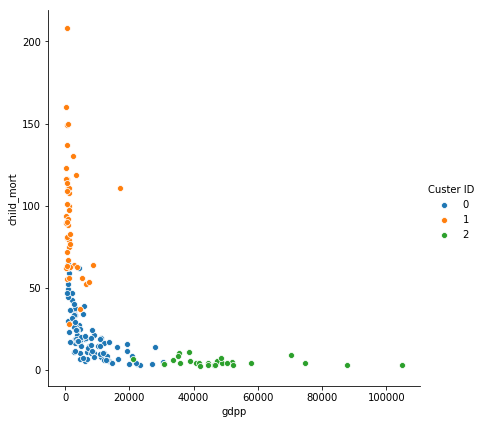

In [26]:
# Plotting for original variables
_ = sns.pairplot(x_vars=["gdpp"], y_vars=["child_mort"], data=country_df_km, hue="cluster_id",size=6)
_._legend.set_title("Custer ID")

In [27]:
# Analysing cluster-wise mean values for the features.
mean_df = pd.DataFrame(pd.Series([0,1,2]));
km_clusters_mean = pd.DataFrame(country_df_km.groupby(["cluster_id"]).mean().reset_index())
mean_df = pd.concat([mean_df, km_clusters_mean], axis=1)
mean_df = mean_df.drop(mean_df.columns[[0,11,12,13,14]],axis=1)
mean_df

,cluster_id,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,20.36,3604.15,547.28,3710.45,13968.02,7.07,73.46,2.24,7979.91
1,1,91.61,879.06,114.82,827.03,3897.35,11.91,59.24,4.99,1909.21
2,2,5.05,31038.24,4327.16,25818.10,50178.57,3.01,80.51,1.76,48114.29


It is quite evident from the above values that the cluster representation is as follows:
<br>Developed - Cluster 2 (High values for GDPP, Income, Life Expectancy; Very low values for child mortality etc )
<br>Developing - Cluster 0 (Moderate values for GDPP, Income, Life Expectancy, child mortality etc)
<br>Under-Developed - Cluster 1 (Low values for GDPP, Income, Life Expectancy; high values for child mortality etc)

Looking at the average values of the featues, It can be clearly seen that the countries that are present in cluster with cluster_id 1 have a high child mortality rate, low life expectancey, low income, low GDP per capita, low health spendings. Also, average total fetility is high. This means that the total population is expected to increase if the current age-fertility rates remain the same. These certainly are the countries in dire need of aid.

#### Illustrating the features using bar-plots

[Text(0, 0.5, 'GDP Per Capita'), Text(0.5, 0, 'Cluster ID')]

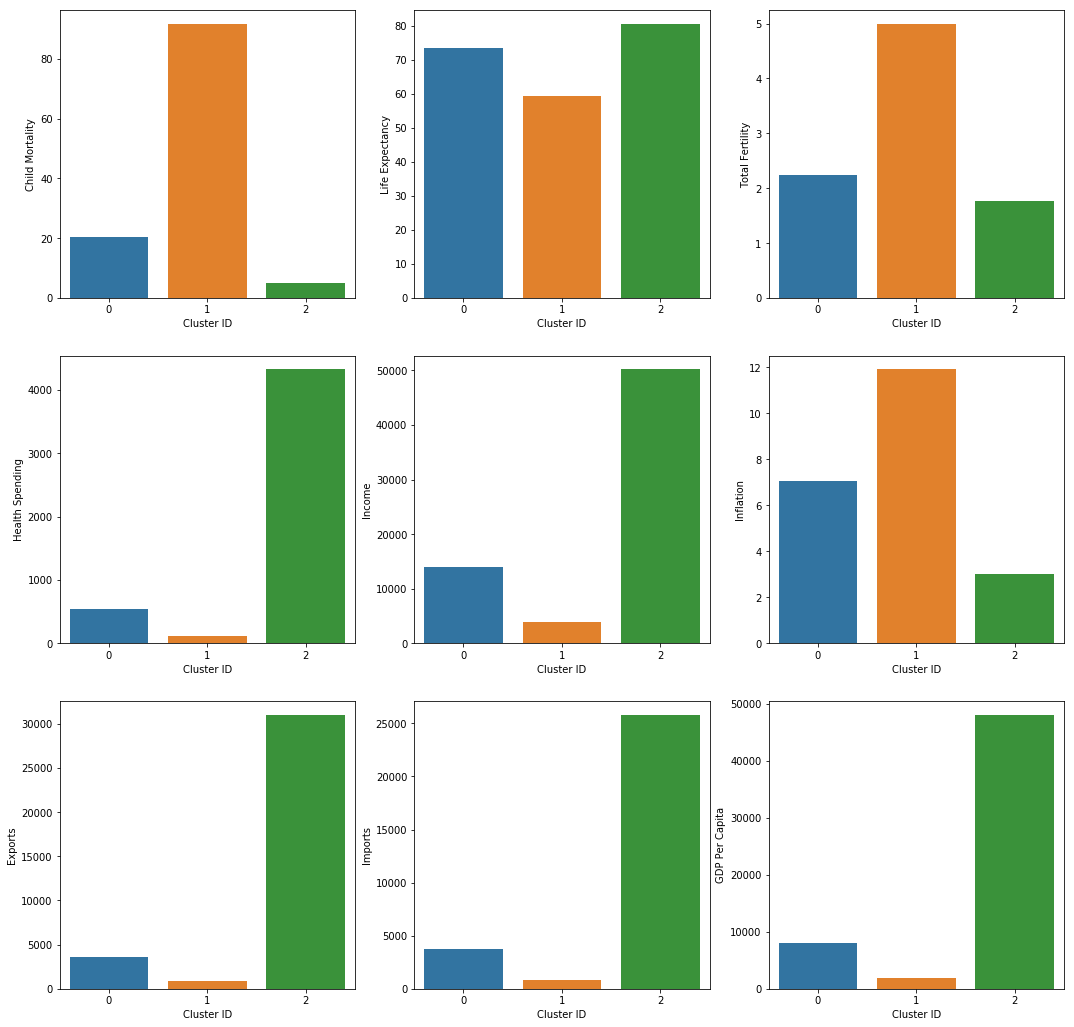

In [29]:
plt.figure(figsize=(18,18))
plt.figure(1)
plt.subplot(331)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.child_mort)
_.set(xlabel='Cluster ID', ylabel='Child Mortality')
plt.subplot(332)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.life_expec)
_.set(xlabel='Cluster ID', ylabel='Life Expectancy')
plt.subplot(333)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.total_fer)
_.set(xlabel='Cluster ID', ylabel='Total Fertility')
plt.subplot(334)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.health)
_.set(xlabel='Cluster ID', ylabel='Health Spending')
plt.subplot(335)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.income)
_.set(xlabel='Cluster ID', ylabel='Income')
plt.subplot(336)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.inflation)
_.set(xlabel='Cluster ID', ylabel='Inflation')
plt.subplot(337)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.exports)
_.set(xlabel='Cluster ID', ylabel='Exports')
plt.subplot(338)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.imports)
_.set(xlabel='Cluster ID', ylabel='Imports')
plt.subplot(339)
_ = sns.barplot(x=mean_df.cluster_id,y=mean_df.gdpp)
_.set(xlabel='Cluster ID', ylabel='GDP Per Capita')

In [30]:
# Under-developed countries
countries_cluster_1 = country_df_km[country_df_km.cluster_id == 1]

In [31]:
# Checking for countries with child mortality rate more than the 95th percentile of the whole dataset.
child_mort_95th = country_df.child_mort.quantile(0.95)
countries_cluster_1[countries_cluster_1.child_mort >= child_mort_95th].sort_values(by='child_mort',ascending=False)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
66,Haiti,208.00,101.29,45.74,428.31,1500,5.45,32.10,3.33,662,-3.93,3.04,-1.79,0.07,1
132,Sierra Leone,160.00,67.03,52.27,137.66,1220,17.20,55.00,5.20,399,-3.21,2.32,-0.13,0.35,1
32,Chad,150.00,330.10,40.63,390.19,1930,6.39,56.50,6.59,897,-3.18,2.35,-1.07,0.54,1
31,Central African Republic,149.00,52.63,17.75,118.19,888,2.01,47.50,5.21,446,-3.23,2.18,-1.61,0.25,1
97,Mali,137.00,161.42,35.26,248.51,1870,4.37,59.50,6.55,708,-2.94,2.01,-1.13,0.51,1
113,Nigeria,130.00,589.49,118.13,405.42,5150,104.00,60.50,5.84,2330,-3.92,3.81,7.84,0.57,1
112,Niger,123.00,77.26,17.96,170.87,814,2.55,58.80,7.49,348,-3.05,2.10,-1.31,0.59,1
3,Angola,119.00,2199.19,100.61,1514.37,5900,22.40,60.10,6.16,3530,-2.72,2.17,0.60,0.44,1
25,Burkina Faso,116.00,110.40,38.76,170.20,1430,6.81,57.90,5.87,575,-2.74,1.66,-0.84,0.33,1
37,"Congo, Dem. Rep.",116.00,137.27,26.42,165.66,609,20.80,57.50,6.54,334,-3.11,2.17,0.36,0.43,1


In [32]:
# Checking for countries with life expectancy less than the 5th percentile of the whole dataset.
life_expec_5th = country_df.life_expec.quantile(0.05)
countries_cluster_1[countries_cluster_1.life_expec <= life_expec_5th].sort_values(by='life_expec',ascending=True)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
66,Haiti,208.00,101.29,45.74,428.31,1500,5.45,32.10,3.33,662,-3.93,3.04,-1.79,0.07,1
87,Lesotho,99.70,460.98,129.87,1181.70,2380,4.15,46.50,3.30,1170,-2.43,1.16,-1.16,-0.19,1
31,Central African Republic,149.00,52.63,17.75,118.19,888,2.01,47.50,5.21,446,-3.23,2.18,-1.61,0.25,1
166,Zambia,83.10,540.20,85.99,451.14,3280,14.00,52.00,5.40,1460,-2.64,1.57,-0.18,0.16,1
94,Malawi,90.50,104.65,30.25,160.19,1030,12.10,53.10,5.31,459,-2.70,1.49,-0.36,0.13,1
137,South Africa,53.70,2082.08,650.83,1994.72,12000,6.35,54.30,2.59,7280,-1.17,0.35,-0.53,-0.09,1
106,Mozambique,101.00,131.99,21.83,193.58,918,7.64,54.50,5.56,419,-2.72,1.54,-0.78,0.20,1
132,Sierra Leone,160.00,67.03,52.27,137.66,1220,17.20,55.00,5.20,399,-3.21,2.32,-0.13,0.35,1
64,Guinea-Bissau,114.00,81.50,46.49,192.54,1390,2.97,55.60,5.05,547,-2.60,1.40,-1.19,0.17,1


In [33]:
# Checking for countries with total_fer more than the 95th percentile of the whole dataset.
total_fer_95th = country_df.total_fer.quantile(0.95)
countries_cluster_1[countries_cluster_1.total_fer >= total_fer_95th].sort_values(by='total_fer',ascending=False)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
112,Niger,123.00,77.26,17.96,170.87,814,2.55,58.80,7.49,348,-3.05,2.10,-1.31,0.59,1
32,Chad,150.00,330.10,40.63,390.19,1930,6.39,56.50,6.59,897,-3.18,2.35,-1.07,0.54,1
97,Mali,137.00,161.42,35.26,248.51,1870,4.37,59.50,6.55,708,-2.94,2.01,-1.13,0.51,1
37,"Congo, Dem. Rep.",116.00,137.27,26.42,165.66,609,20.80,57.50,6.54,334,-3.11,2.17,0.36,0.43,1
26,Burundi,93.60,20.61,26.80,90.55,764,12.30,57.70,6.26,231,-2.76,1.62,-0.29,0.32,1
149,Timor-Leste,62.60,79.20,328.32,1000.80,1850,26.50,71.10,6.23,3600,-2.00,1.08,1.38,0.44,1
3,Angola,119.00,2199.19,100.61,1514.37,5900,22.40,60.10,6.16,3530,-2.72,2.17,0.60,0.44,1
155,Uganda,81.00,101.75,53.61,170.17,1540,10.60,56.80,6.15,595,-2.61,1.46,-0.41,0.27,1
25,Burkina Faso,116.00,110.40,38.76,170.20,1430,6.81,57.90,5.87,575,-2.74,1.66,-0.84,0.33,1


In [34]:
# Checking for countries with health spending less than the 5th percentile of the whole dataset.
health_5th = country_df.health.quantile(0.05)
countries_cluster_1[countries_cluster_1.health <= health_5th].sort_values(by='health',ascending=True)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
50,Eritrea,55.20,23.09,12.82,112.31,1420,11.60,61.70,4.61,482,-1.94,0.49,-0.04,-0.05,1
93,Madagascar,62.20,103.25,15.57,177.59,1390,8.79,60.80,4.60,413,-1.99,0.55,-0.34,-0.04,1
31,Central African Republic,149.00,52.63,17.75,118.19,888,2.01,47.50,5.21,446,-3.23,2.18,-1.61,0.25,1
112,Niger,123.00,77.26,17.96,170.87,814,2.55,58.80,7.49,348,-3.05,2.10,-1.31,0.59,1
106,Mozambique,101.00,131.99,21.83,193.58,918,7.64,54.50,5.56,419,-2.72,1.54,-0.78,0.20,1
116,Pakistan,92.10,140.40,22.88,201.76,4280,10.90,65.30,3.85,1040,-1.86,0.57,-0.10,-0.01,1
37,"Congo, Dem. Rep.",116.00,137.27,26.42,165.66,609,20.80,57.50,6.54,334,-3.11,2.17,0.36,0.43,1


#### From the above analysis, we can summarize the following:
#### Haiti is in dire need of aid since it has very high child mortality rate and very low expectancy. It's possible that this country is prevalant with diseases, or lack of resources that lead to children dying in early stages of life, and adults not being able to stay alive for long.
#### Sierra Leone and Chad are in dire need of aid to tackle very high child mortality rate by spending more in child-care
#### Lesotho and Central African Republic are in dire need of aid to tackle very low life expectancy by spending more in healthcare programs.
#### Niger and Mali can be alloted some aid to spend in awareness programs to educate people about birth-control since Niger has very high total fertility rate.
#### Mozambique and Congo, Dem. Rep. are two other countries which can be alloted aid. These countries have very low spendings on health, high child mortality rate and low life expectancy.
#### Nigeria, Angola, Burkina Faso and Guinea-Bissau are other countries which need aid since they have high child mortality rate and low life expectancy.

### Hierarchical Clustering

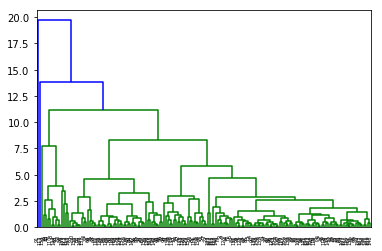

In [35]:
# Performing hierarchical clustering, using method=average.
mergings = linkage(pca_df, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [36]:
# Taking the number of clusters = 5 for hierarchical clustering
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
country_df_hc =  pd.concat([country_df, pca_df, clusterCut], axis=1)
country_df_hc.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','PC1','PC2','PC3','PC4','cluster_id']
country_df_hc.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
0,Afghanistan,90.20,55.30,41.92,248.30,1610,9.44,56.20,5.82,553,-2.63,1.47,-0.54,0.24,0
1,Albania,16.60,1145.20,267.89,1987.74,9930,4.49,76.30,1.65,4090,-0.02,-1.43,-0.01,-0.44,1
2,Algeria,27.30,1712.64,185.98,1400.44,12900,16.10,76.50,2.89,4460,-0.46,-0.68,0.96,-0.18,1
3,Angola,119.00,2199.19,100.61,1514.37,5900,22.40,60.10,6.16,3530,-2.72,2.17,0.60,0.44,0
4,Antigua and Barbuda,10.30,5551.00,735.66,7185.80,19100,1.44,76.80,2.13,12200,0.65,-1.02,-0.24,-0.27,1


In [37]:
# Analysing cluster-wise mean values for the features.
mean_df = pd.DataFrame(pd.Series([0,1,2,3,4]));
hc_clusters_mean = pd.DataFrame(country_df_hc.groupby(["cluster_id"]).mean().reset_index())
mean_df = pd.concat([mean_df, hc_clusters_mean], axis=1)
mean_df = mean_df.drop(mean_df.columns[[0,11,12,13,14]],axis=1)
mean_df

,cluster_id,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,90.79,885.22,114.75,836.00,3870.70,9.95,59.21,4.97,1900.26
1,1,18.56,5115.82,857.67,4943.14,17679.71,6.72,74.32,2.17,11638.19
2,2,4.37,34375.21,5257.60,28383.62,53264.29,1.83,80.63,1.79,54142.86
3,3,2.80,183750.00,8158.50,149100.00,91700.00,3.62,81.30,1.63,105000.00
4,4,130.00,589.49,118.13,405.42,5150.00,104.00,60.50,5.84,2330.00


Looking at the above values, It can be clearly seen that the countries in need of aid fall into clusters with cluster_id 0 and 4. These are the clusters with high child mortality, low life expectancy, low income, low gdpp and low health spending.

In [38]:
country_df_hc_aid = country_df_hc[country_df_hc.cluster_id.isin([0,4])]

In [39]:
# Checking for countries with child mortality rate more than the 95th percentile of the whole dataset.
child_mort_95th = country_df.child_mort.quantile(0.95)
country_df_hc_aid[country_df_hc_aid.child_mort >= child_mort_95th].sort_values(by='child_mort',ascending=False)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
66,Haiti,208.00,101.29,45.74,428.31,1500,5.45,32.10,3.33,662,-3.93,3.04,-1.79,0.07,0
132,Sierra Leone,160.00,67.03,52.27,137.66,1220,17.20,55.00,5.20,399,-3.21,2.32,-0.13,0.35,0
32,Chad,150.00,330.10,40.63,390.19,1930,6.39,56.50,6.59,897,-3.18,2.35,-1.07,0.54,0
31,Central African Republic,149.00,52.63,17.75,118.19,888,2.01,47.50,5.21,446,-3.23,2.18,-1.61,0.25,0
97,Mali,137.00,161.42,35.26,248.51,1870,4.37,59.50,6.55,708,-2.94,2.01,-1.13,0.51,0
113,Nigeria,130.00,589.49,118.13,405.42,5150,104.00,60.50,5.84,2330,-3.92,3.81,7.84,0.57,4
112,Niger,123.00,77.26,17.96,170.87,814,2.55,58.80,7.49,348,-3.05,2.10,-1.31,0.59,0
3,Angola,119.00,2199.19,100.61,1514.37,5900,22.40,60.10,6.16,3530,-2.72,2.17,0.60,0.44,0
25,Burkina Faso,116.00,110.40,38.76,170.20,1430,6.81,57.90,5.87,575,-2.74,1.66,-0.84,0.33,0
37,"Congo, Dem. Rep.",116.00,137.27,26.42,165.66,609,20.80,57.50,6.54,334,-3.11,2.17,0.36,0.43,0


In [40]:
# Checking for countries with life expectancy less than the 5th percentile of the whole dataset.
life_expec_5th = country_df.life_expec.quantile(0.05)
country_df_hc_aid[country_df_hc_aid.life_expec <= life_expec_5th].sort_values(by='life_expec',ascending=True)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
66,Haiti,208.00,101.29,45.74,428.31,1500,5.45,32.10,3.33,662,-3.93,3.04,-1.79,0.07,0
87,Lesotho,99.70,460.98,129.87,1181.70,2380,4.15,46.50,3.30,1170,-2.43,1.16,-1.16,-0.19,0
31,Central African Republic,149.00,52.63,17.75,118.19,888,2.01,47.50,5.21,446,-3.23,2.18,-1.61,0.25,0
166,Zambia,83.10,540.20,85.99,451.14,3280,14.00,52.00,5.40,1460,-2.64,1.57,-0.18,0.16,0
94,Malawi,90.50,104.65,30.25,160.19,1030,12.10,53.10,5.31,459,-2.70,1.49,-0.36,0.13,0
137,South Africa,53.70,2082.08,650.83,1994.72,12000,6.35,54.30,2.59,7280,-1.17,0.35,-0.53,-0.09,0
106,Mozambique,101.00,131.99,21.83,193.58,918,7.64,54.50,5.56,419,-2.72,1.54,-0.78,0.20,0
132,Sierra Leone,160.00,67.03,52.27,137.66,1220,17.20,55.00,5.20,399,-3.21,2.32,-0.13,0.35,0
64,Guinea-Bissau,114.00,81.50,46.49,192.54,1390,2.97,55.60,5.05,547,-2.60,1.40,-1.19,0.17,0


In [41]:
# Checking for countries with total_fer more than the 95th percentile of the whole dataset.
total_fer_95th = country_df.total_fer.quantile(0.95)
country_df_hc_aid[country_df_hc_aid.total_fer >= total_fer_95th].sort_values(by='total_fer',ascending=False)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
112,Niger,123.00,77.26,17.96,170.87,814,2.55,58.80,7.49,348,-3.05,2.10,-1.31,0.59,0
32,Chad,150.00,330.10,40.63,390.19,1930,6.39,56.50,6.59,897,-3.18,2.35,-1.07,0.54,0
97,Mali,137.00,161.42,35.26,248.51,1870,4.37,59.50,6.55,708,-2.94,2.01,-1.13,0.51,0
37,"Congo, Dem. Rep.",116.00,137.27,26.42,165.66,609,20.80,57.50,6.54,334,-3.11,2.17,0.36,0.43,0
26,Burundi,93.60,20.61,26.80,90.55,764,12.30,57.70,6.26,231,-2.76,1.62,-0.29,0.32,0
149,Timor-Leste,62.60,79.20,328.32,1000.80,1850,26.50,71.10,6.23,3600,-2.00,1.08,1.38,0.44,0
3,Angola,119.00,2199.19,100.61,1514.37,5900,22.40,60.10,6.16,3530,-2.72,2.17,0.60,0.44,0
155,Uganda,81.00,101.75,53.61,170.17,1540,10.60,56.80,6.15,595,-2.61,1.46,-0.41,0.27,0
25,Burkina Faso,116.00,110.40,38.76,170.20,1430,6.81,57.90,5.87,575,-2.74,1.66,-0.84,0.33,0


In [42]:
# Checking for countries with health spending less than the 5th percentile of the whole dataset.
health_5th = country_df.health.quantile(0.05)
country_df_hc_aid[country_df_hc_aid.health <= health_5th].sort_values(by='health',ascending=True)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
50,Eritrea,55.20,23.09,12.82,112.31,1420,11.60,61.70,4.61,482,-1.94,0.49,-0.04,-0.05,0
93,Madagascar,62.20,103.25,15.57,177.59,1390,8.79,60.80,4.60,413,-1.99,0.55,-0.34,-0.04,0
31,Central African Republic,149.00,52.63,17.75,118.19,888,2.01,47.50,5.21,446,-3.23,2.18,-1.61,0.25,0
112,Niger,123.00,77.26,17.96,170.87,814,2.55,58.80,7.49,348,-3.05,2.10,-1.31,0.59,0
106,Mozambique,101.00,131.99,21.83,193.58,918,7.64,54.50,5.56,419,-2.72,1.54,-0.78,0.20,0
116,Pakistan,92.10,140.40,22.88,201.76,4280,10.90,65.30,3.85,1040,-1.86,0.57,-0.10,-0.01,0
37,"Congo, Dem. Rep.",116.00,137.27,26.42,165.66,609,20.80,57.50,6.54,334,-3.11,2.17,0.36,0.43,0


#### The results here are quite similar to those obtained after K-Means clustering.

#### As per the above analysis, following is the final list of countries that are in direst need of aid:
#### Haiti, Sierra Leone, Chad, Lesotho, Central African Republic, Niger, Mali, Mozambique, Congo, Dem. Rep, Nigeria, Angola, Burkina Faso and Guinea-Bissau